Test Accuracy: 0.7772585669781932
Confusion Matrix:
[[459  27]
 [116  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       486
           1       0.60      0.26      0.36       156

    accuracy                           0.78       642
   macro avg       0.70      0.60      0.61       642
weighted avg       0.75      0.78      0.74       642



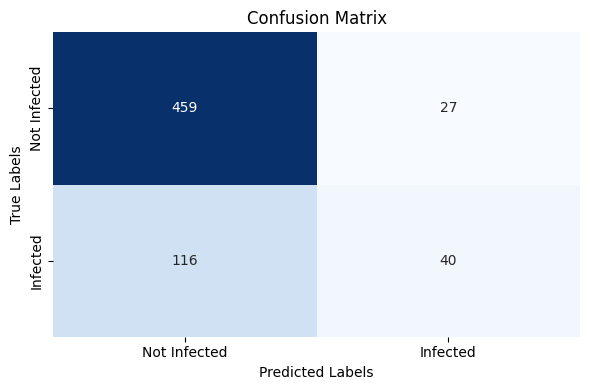

AIDS Detection: Yes, AIDS is detected


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('AIDS_Classification.csv')

# Handle missing values - fill with median for numerical, mode for categorical
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering
df['cd4_cd8_ratio'] = df['cd40'] / df['cd80']
df['cd4_change'] = df['cd420'] - df['cd40']
df['cd8_change'] = df['cd820'] - df['cd80']

# Drop unnecessary columns
df.drop(['time', 'str2', 'strat'], axis=1, errors='ignore', inplace=True)

# Convert categorical variables to dummy variables
cat_cols = ['trt', 'gender', 'race', 'homo', 'drugs', 'oprior', 'z30', 'symptom', 'treat', 'offtrt']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split data into features and target
X = df.drop('infected', axis=1)
y = df['infected']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820',
            'cd4_cd8_ratio', 'cd4_change', 'cd8_change']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Display Classification Report and Confusion Matrix
def display_results(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

display_results(y_test, y_pred)

# Plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Infected", "Infected"],
                yticklabels=["Not Infected", "Infected"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# Display if AIDS is detected or not
def detect_aids(predictions):
    return "Yes, AIDS is detected" if 1 in predictions else "No, AIDS is not detected"

aids_detection = detect_aids(y_pred)
print("AIDS Detection:", aids_detection)


Test Accuracy: 0.7133956386292835
Confusion Matrix:
[[357 129]
 [ 55 101]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.73      0.80       486
           1       0.44      0.65      0.52       156

    accuracy                           0.71       642
   macro avg       0.65      0.69      0.66       642
weighted avg       0.76      0.71      0.73       642



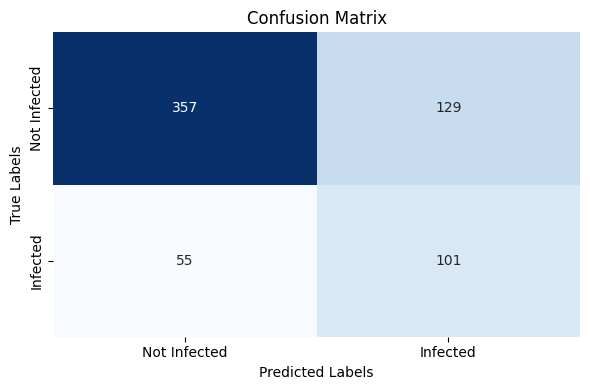

AIDS Detection: Yes, AIDS is detected


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('AIDS_Classification.csv')

# Handle missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering
df['cd4_cd8_ratio'] = df['cd40'] / df['cd80']
df['cd4_change'] = df['cd420'] - df['cd40']
df['cd8_change'] = df['cd820'] - df['cd80']

# Drop unnecessary columns
df.drop(['time', 'str2', 'strat'], axis=1, errors='ignore', inplace=True)

# Convert categorical to dummy variables
cat_cols = ['trt', 'gender', 'race', 'homo', 'drugs', 'oprior', 'z30', 'symptom', 'treat', 'offtrt']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Features and target
X = df.drop('infected', axis=1)
y = df['infected']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# Feature scaling
scaler = StandardScaler()
num_cols = ['age', 'wtkg', 'karnof', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820',
            'cd4_cd8_ratio', 'cd4_change', 'cd8_change']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train Random Forest with class_weight
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# Predict probabilities for threshold tuning
y_proba = rf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.4).astype(int)  # Lowered threshold from 0.5 to 0.4 for better recall

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

def display_results(y_true, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

display_results(y_test, y_pred)

# Confusion matrix plot
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Not Infected", "Infected"],
                yticklabels=["Not Infected", "Infected"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# AIDS detection summary
def detect_aids(predictions):
    return "Yes, AIDS is detected" if 1 in predictions else "No, AIDS is not detected"

aids_detection = detect_aids(y_pred)
print("AIDS Detection:", aids_detection)
